# Customer Segmentation BDA Project - Part 2

## Clustering

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import year, max as spark_max, lit, col, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from minisom import MiniSom
from collections import defaultdict

In [0]:
df = spark.read.csv("dbfs:/FileStore/tables/marketing_campaign_preprocess.csv", header=True, inferSchema=True)
df.show()


+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+-----------------+--------+-------------+-----------------------+------------------+---+
|Year_Birth| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|Total_Spend|NumTotalPurchases|Children|Days_Customer|AcceptedCampaigns_Total|Website_Engagement|Age|
+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+---------

In [0]:
metric_features = [
    "Income",
    "Recency",
    "Total_Spend",
    "Days_Customer",
    "Age",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumTotalPurchases",
    "Children",
    "AcceptedCampaigns_Total",
    "Website_Engagement",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth", 
    "Kidhome",
    "Teenhome",
    "Year_Birth"
]

In [0]:
non_metric_features = [
    "Education",
    "Marital_Status",
    "Complain",
    "Response",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5"
]

In [0]:
df.printSchema()

root
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullable = true)
 |-- AcceptedCmp1: integer (nullable = true)
 |-

In [0]:
# Encode categorical columns
education_indexer = StringIndexer(inputCol='Education', outputCol='EducationIndex')
marital_indexer = StringIndexer(inputCol='Marital_Status', outputCol='MaritalStatusIndex')

# OneHotEncode indexed columns
education_encoder = OneHotEncoder(inputCol='EducationIndex', outputCol='EducationVec')
marital_encoder = OneHotEncoder(inputCol='MaritalStatusIndex', outputCol='MaritalStatusVec')


In [0]:
# define columns to scale
scaled_columns = [
    'Income',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Total_Spend',
    'NumTotalPurchases',
    'Website_Engagement',
    'Age',
    'Days_Customer'
]

In [0]:
# columns not scaled (binary / small counts)
binary_columns = [
    'Children',
    'Complain',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Response',
    'AcceptedCampaigns_Total'
]


In [0]:
# encoded categorical columns
encoded_columns = [
    'EducationVec',
    'MaritalStatusVec'
]


In [0]:
# assemble continuous features
continuous_assembler = VectorAssembler(
    inputCols=scaled_columns,
    outputCol='continuousFeatures'
)

# scale continuous features
scaler = StandardScaler(
    inputCol='continuousFeatures',
    outputCol='scaledContinuousFeatures',
    withStd=True,
    withMean=True
)

In [0]:
# assemble binary and encoded columns
other_assembler = VectorAssembler(
    inputCols=binary_columns + encoded_columns,
    outputCol='otherFeatures'
)

In [0]:
final_assembler = VectorAssembler(
    inputCols=['scaledContinuousFeatures', 'otherFeatures'],
    outputCol='finalFeatures'
)

In [0]:
pipeline = Pipeline(stages=[
    education_indexer,
    marital_indexer,
    education_encoder,
    marital_encoder,
    continuous_assembler,
    scaler,
    other_assembler,
    final_assembler
])

# Fit and transform
pipeline_model = pipeline.fit(df)
df_prepared = pipeline_model.transform(df)

# Self Organizing Maps - SOM's

##Customer Profile Perspective

In [0]:
customer_profile_features = [
    'Income', 'Recency', 'Total_Spend', 'Days_Customer', 'Age', 'Website_Engagement',
    'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases', 'NumDealsPurchases',
    'NumWebVisitsMonth', 'NumTotalPurchases', 'Children'
]

# Assemble and extract Customer Profile feature_array
customer_assembler = VectorAssembler(
    inputCols=customer_profile_features,
    outputCol='customerFeatures'
)

df_customer = customer_assembler.transform(df_prepared)

feature_array_customer = np.array(
    df_customer.select('customerFeatures')
    .rdd.map(lambda row: row[0].toArray())
    .collect()
)

print("Customer Profile feature array shape:", feature_array_customer.shape)

Customer Profile feature array shape: (2216, 13)


In [0]:
# Train SOM
som_x = 10
som_y = 10

som_customer = MiniSom(
    x=som_x, y=som_y,
    input_len=feature_array_customer.shape[1],
    sigma=1.0, learning_rate=0.5
)

som_customer.random_weights_init(feature_array_customer)
som_customer.train_random(feature_array_customer, num_iteration=1000)

print("Customer Profile SOM training completed!")

Customer Profile SOM training completed!


####U-Matrix

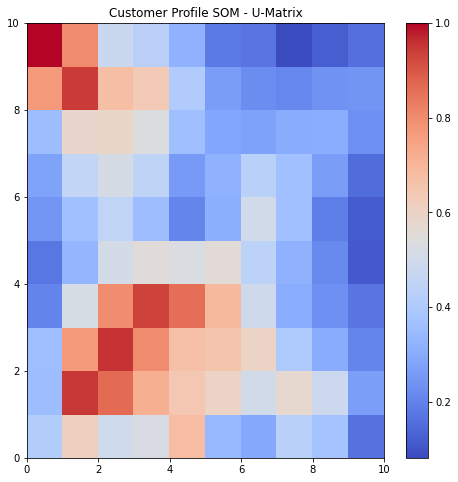

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Customer Profile SOM - U-Matrix")
plt.pcolor(som_customer.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.show()

The U-Matrix of the Customer Profile SOM shows clear cluster boundaries in multiple regions, suggesting the existence of distinct customer segments based on their profile features. Some areas indicate homogeneous customer groups, while others reveal significant differences in profiles — providing valuable insights for differentiated marketing strategies.


####Component Planes

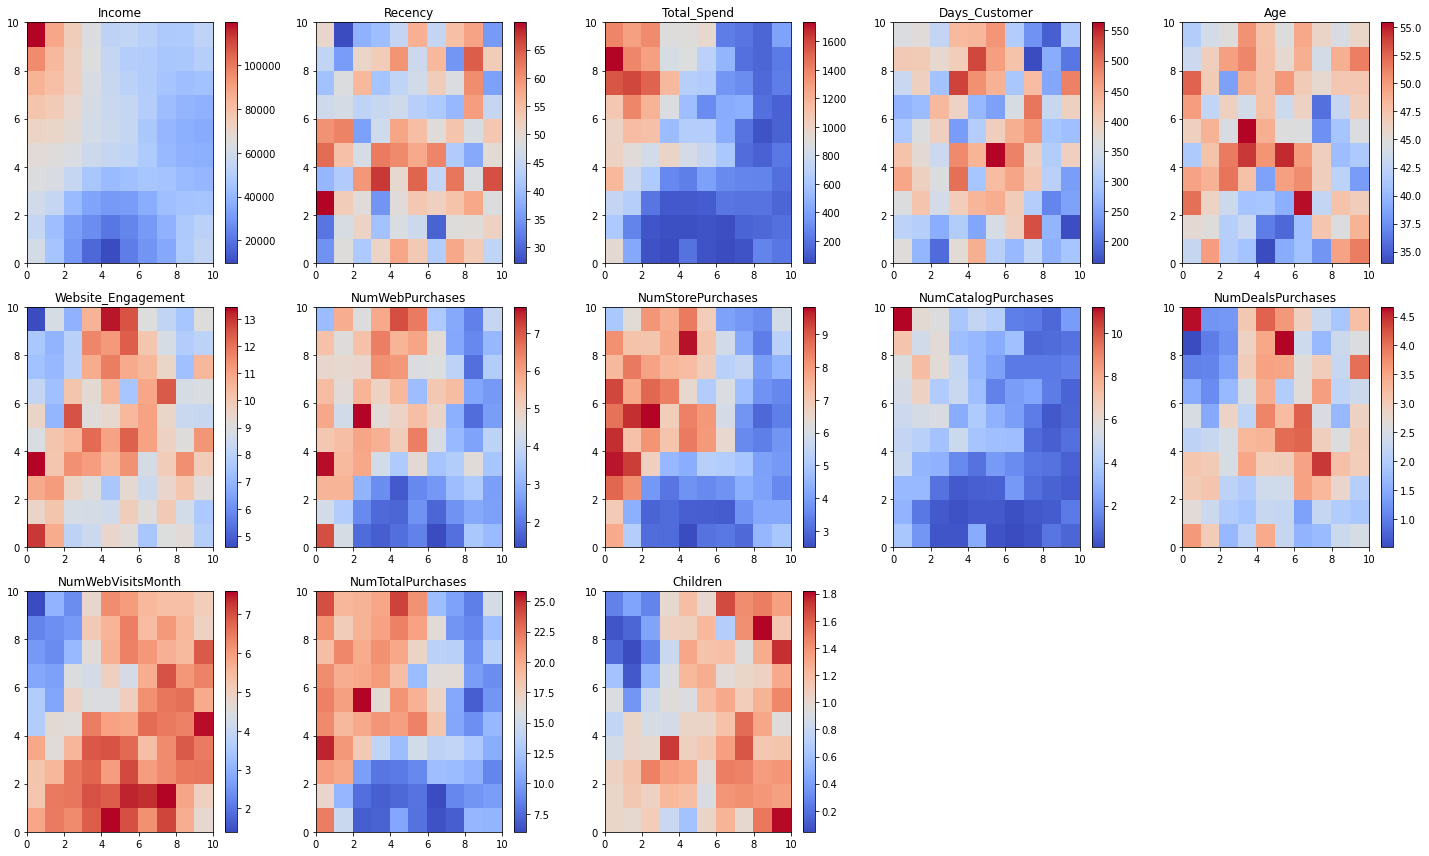

In [0]:
customer_feature_names = customer_profile_features

num_features = feature_array_customer.shape[1]
n_cols = 5
n_rows = (num_features // n_cols) + int(num_features % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

for i, ax in enumerate(axes.flat):
    if i < num_features:
        plane = som_customer._weights[:, :, i]
        im = ax.pcolor(plane.T, cmap='coolwarm')
        ax.set_title(customer_feature_names[i], fontsize=12)
        fig.colorbar(im, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


The Component Planes of the Customer Profile SOM highlight clear differences in customer segments:

- Income and Total Spend show a strong separation between high and low-value customers.
- Website Engagement and NumWebVisitsMonth reveal varying levels of digital interaction.
- Distinct patterns in purchase channels (Web vs. Store) suggest opportunities for targeted campaigns.
- The presence of family-oriented segments (Children > 0) offers potential for personalized marketing.

Overall, the SOM confirms that the customer base is heterogeneous, with actionable insights for marketing strategies.


####Hit Map

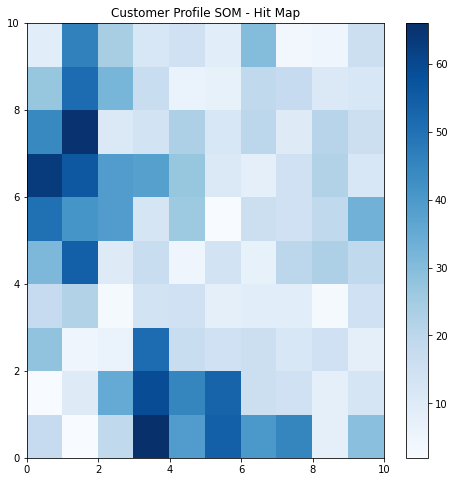

In [0]:
bmu_counts = defaultdict(int)

for x in feature_array_customer:
    bmu = som_customer.winner(x)
    bmu_counts[bmu] += 1

hit_map = np.zeros((som_x, som_y))
for (x_bmu, y_bmu), count in bmu_counts.items():
    hit_map[x_bmu, y_bmu] = count

plt.figure(figsize=(8, 8))
plt.title("Customer Profile SOM - Hit Map")
plt.pcolor(hit_map.T, cmap='Blues')
plt.colorbar()
plt.show()

The Hit Map of the Customer Profile SOM shows that the map is well utilized, with several dense clusters and a good distribution of customers across the SOM. This indicates that the model successfully captured multiple distinct customer segments within the dataset.


##Product / Spend Preferences Perspective

In [0]:
product_features = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]

# Assemble and extract Product Preferences feature_array
product_assembler = VectorAssembler(
    inputCols=product_features,
    outputCol='productFeatures'
)

df_product = product_assembler.transform(df_prepared)

feature_array_product = np.array(
    df_product.select('productFeatures')
    .rdd.map(lambda row: row[0].toArray())
    .collect()
)

print("Product Preferences feature array shape:", feature_array_product.shape)

Product Preferences feature array shape: (2216, 6)


In [0]:
# Train SOM
som_x = 10
som_y = 10

som_product = MiniSom(
    x=som_x, y=som_y,
    input_len=feature_array_product.shape[1],
    sigma=1.0, learning_rate=0.5
)

som_product.random_weights_init(feature_array_product)
som_product.train_random(feature_array_product, num_iteration=1000)

print("Product Preferences SOM training completed!")

Product Preferences SOM training completed!


####U-Matrix

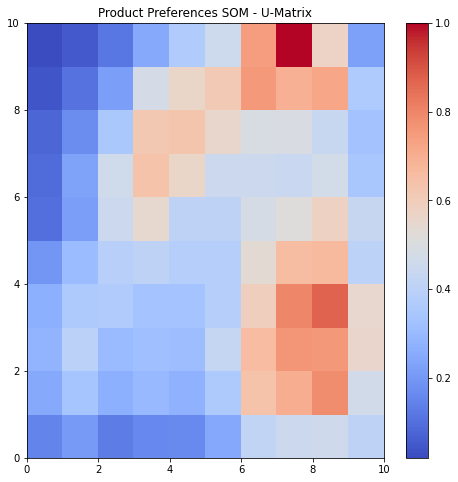

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Product Preferences SOM - U-Matrix")
plt.pcolor(som_product.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.show()


The Product Preferences SOM U-Matrix reveals well-defined clusters of customer behavior regarding product categories. Clear boundaries indicate the presence of segments with distinct consumption patterns, suggesting opportunities for product-focused targeting.


####Component Planes

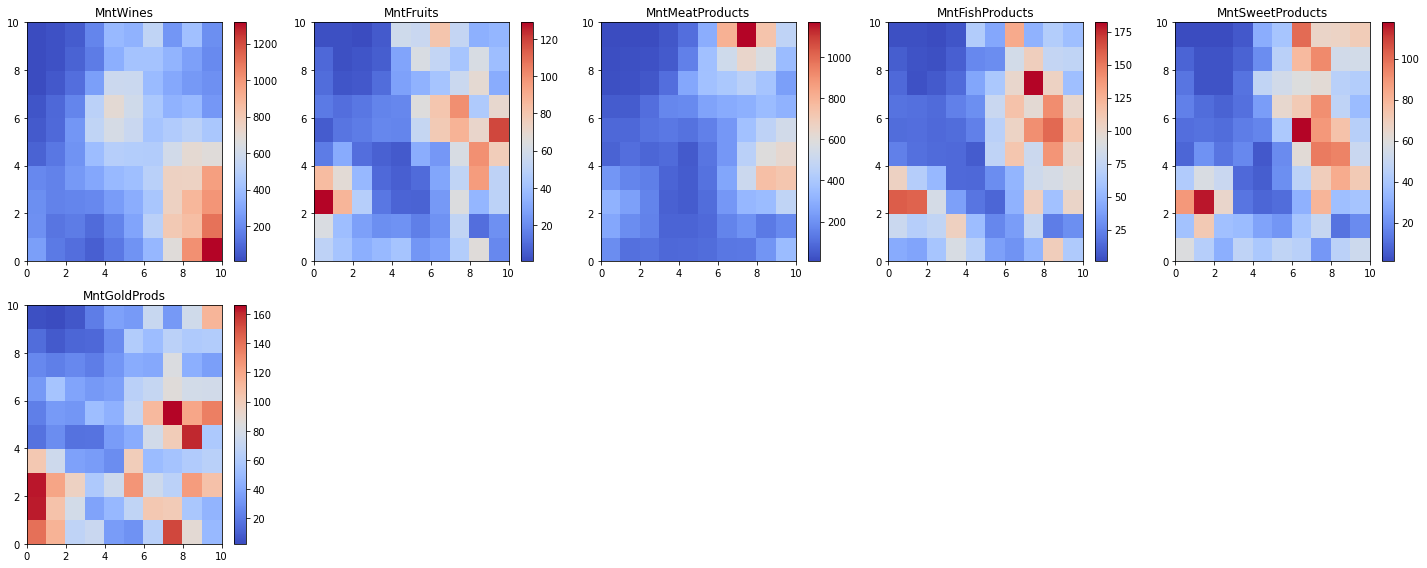

In [0]:
product_feature_names = product_features

num_features = feature_array_product.shape[1]
n_cols = 5
n_rows = (num_features // n_cols) + int(num_features % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

for i, ax in enumerate(axes.flat):
    if i < num_features:
        plane = som_product._weights[:, :, i]
        im = ax.pcolor(plane.T, cmap='coolwarm')
        ax.set_title(product_feature_names[i], fontsize=12)
        fig.colorbar(im, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


The Product Preferences SOM shows clear differences in how customers engage with each product category. Some groups of customers display high interest in specific categories such as wines, meats, or sweets, while others have consistently lower levels of spending across most products. The variation across the map suggests that product preferences are diverse within the customer base.

####Hit Map

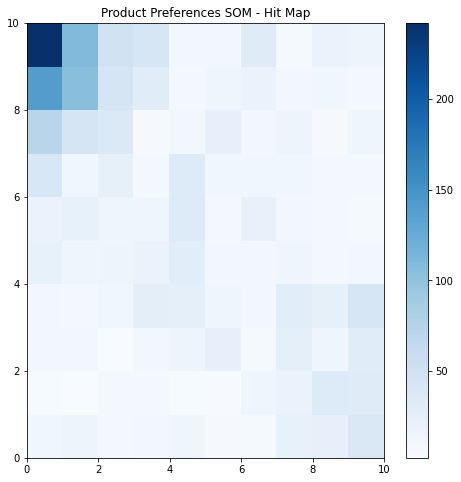

In [0]:
bmu_counts = defaultdict(int)

for x in feature_array_product:
    bmu = som_product.winner(x)
    bmu_counts[bmu] += 1

hit_map = np.zeros((som_x, som_y))
for (x_bmu, y_bmu), count in bmu_counts.items():
    hit_map[x_bmu, y_bmu] = count

plt.figure(figsize=(8, 8))
plt.title("Product Preferences SOM - Hit Map")
plt.pcolor(hit_map.T, cmap='Blues')
plt.colorbar()
plt.show()

The Hit Map of the Product Preferences SOM shows that a large proportion of customers share similar product consumption patterns, as indicated by the dense region in the upper-left area. More unique preferences appear in smaller groups scattered across the map.


##Campaign Response Perspective

In [0]:
# Train SOM
campaign_features = [
    'Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
    'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'AcceptedCampaigns_Total'
]

# Assemble and extract Campaign Response feature_array
campaign_assembler = VectorAssembler(
    inputCols=campaign_features,
    outputCol='campaignFeatures'
)

df_campaign = campaign_assembler.transform(df_prepared)

feature_array_campaign = np.array(
    df_campaign.select('campaignFeatures')
    .rdd.map(lambda row: row[0].toArray())
    .collect()
)

print("Campaign Response feature array shape:", feature_array_campaign.shape)

Campaign Response feature array shape: (2216, 8)


In [0]:
som_x = 10
som_y = 10

som_campaign = MiniSom(
    x=som_x, y=som_y,
    input_len=feature_array_campaign.shape[1],
    sigma=1.0, learning_rate=0.5
)

som_campaign.random_weights_init(feature_array_campaign)
som_campaign.train_random(feature_array_campaign, num_iteration=1000)

print("Campaign Response SOM training completed!")

Campaign Response SOM training completed!


####U-Matrix

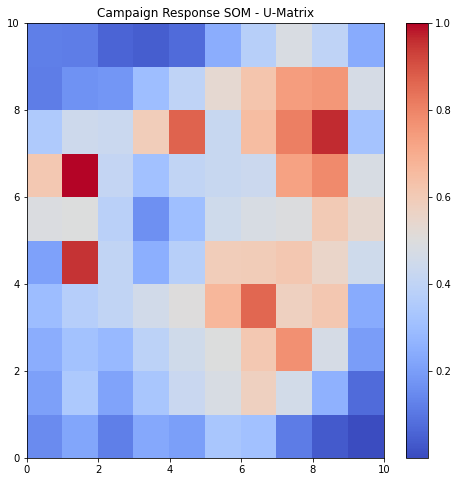

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Campaign Response SOM - U-Matrix")
plt.pcolor(som_campaign.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.show()


The U-Matrix of the Campaign Response SOM suggests that customers exhibit diverse behaviors in relation to marketing campaigns. Clear boundaries indicate that some groups respond differently to campaign efforts, while other areas of the map reflect more consistent response patterns.


####Component Planes

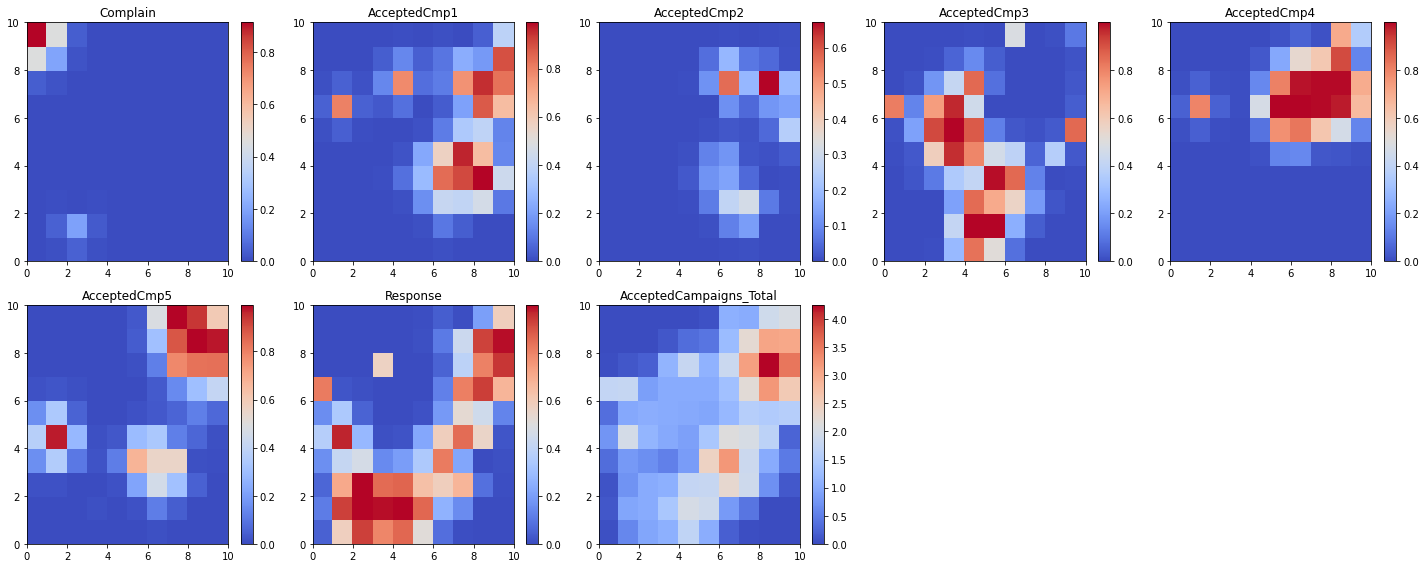

In [0]:
campaign_feature_names = campaign_features

num_features = feature_array_campaign.shape[1]
n_cols = 5
n_rows = (num_features // n_cols) + int(num_features % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

for i, ax in enumerate(axes.flat):
    if i < num_features:
        plane = som_campaign._weights[:, :, i]
        im = ax.pcolor(plane.T, cmap='coolwarm')
        ax.set_title(campaign_feature_names[i], fontsize=12)
        fig.colorbar(im, ax=ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

The Component Planes of the Campaign Response SOM show that most customers do not respond to campaigns, as expected. However, distinct groups of responders are clearly visible across different campaigns, indicating that some segments of the customer base are more engaged with marketing efforts.


####Hit Map

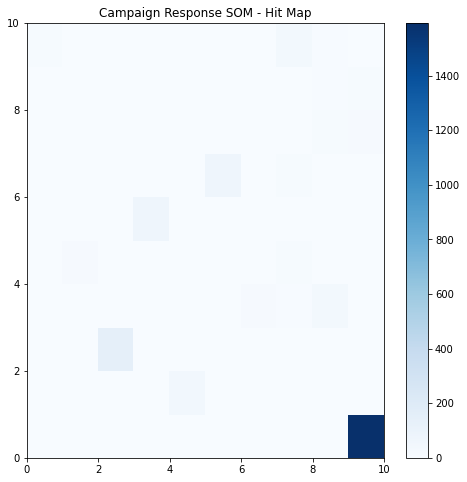

In [0]:
bmu_counts = defaultdict(int)

for x in feature_array_campaign:
    bmu = som_campaign.winner(x)
    bmu_counts[bmu] += 1

hit_map = np.zeros((som_x, som_y))
for (x_bmu, y_bmu), count in bmu_counts.items():
    hit_map[x_bmu, y_bmu] = count

plt.figure(figsize=(8, 8))
plt.title("Campaign Response SOM - Hit Map")
plt.pcolor(hit_map.T, cmap='Blues')
plt.colorbar()
plt.show()

The Campaign Response SOM Hit Map shows that the majority of customers exhibit similar behavior in relation to marketing campaigns, as reflected by the concentration in a single BMU. Smaller groups of responders are mapped to isolated cells, confirming that only a few customers actively engage with campaign efforts.
